In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [18]:
df = pd.read_csv("/content/Microsoft_Stock.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close'

In [19]:
df = df.dropna()

In [20]:
X = df[features].values
y = df[target].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()


In [21]:
def create_sequences(X, y, seq_len=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)


In [22]:
SEQ_LEN = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=25)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)


In [23]:
class GPFormer(nn.Module):
    def __init__(self, input_dim, d_model=64, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(SEQ_LEN, d_model))  # PE learnable
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoding
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x[-1]
        out = self.decoder(x)
        return out


Epoch 10/50 - Train Loss: 0.0105 - Test Loss: 0.0068
Epoch 20/50 - Train Loss: 0.0107 - Test Loss: 0.0061
Epoch 30/50 - Train Loss: 0.0091 - Test Loss: 0.0042
Epoch 40/50 - Train Loss: 0.0092 - Test Loss: 0.0042
Epoch 50/50 - Train Loss: 0.0089 - Test Loss: 0.0043


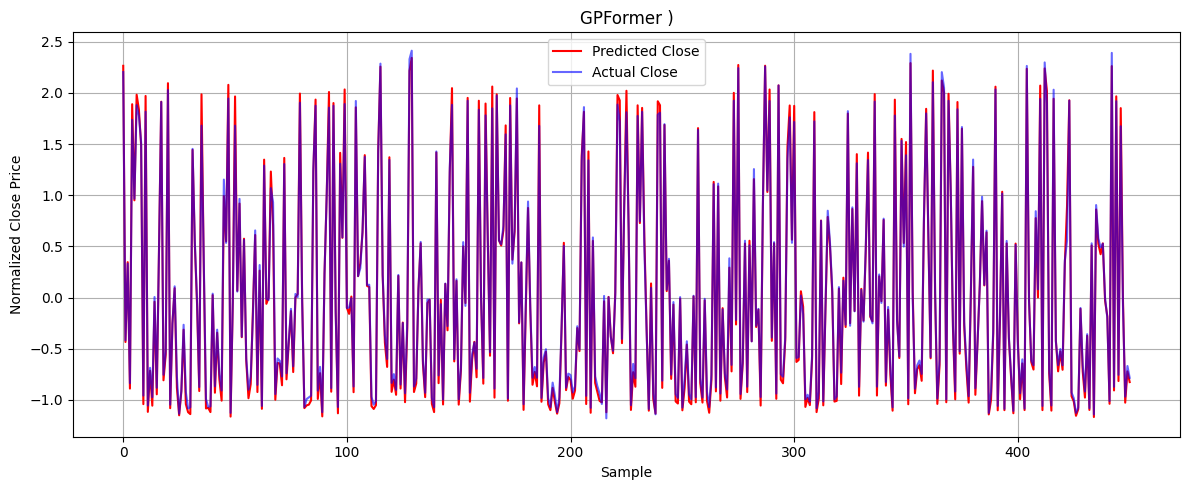

In [24]:
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = loss_fn(output, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_t)
            val_loss = loss_fn(val_pred, y_test_t)
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {loss.item():.4f} - Test Loss: {val_loss.item():.4f}")

model.eval()
with torch.no_grad():
    preds = model(X_test_t).squeeze().numpy()
    truth = y_test_t.squeeze().numpy()

plt.figure(figsize=(12, 5))
plt.plot(preds, label="Predicted Close", color='red')
plt.plot(truth, label="Actual Close", color='blue', alpha=0.6)
plt.title("GPFormer )")
plt.xlabel("Sample")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
